# Restricted Boltzmann Machine

---
---

Suppose you ask a bunch of users to rate a set of movies on a 0-100 scale. In classical factor analysis, you could then try to explain each movie and user in terms of a **set of latent factors**. For example, movies like *Star Wars* and *Lord of the Rings* might have strong associations with a latent science fiction and fantasy factor, and users who like *Wall-E* and *Toy Story* might have strong associations with a latent Pixar factor.

Restricted Boltzmann Machines essentially perform a binary version of factor analysis. (This is one way of thinking about RBMs; there are, of course, others, and lots of different ways to use RBMs) Instead of users rating a set of movies on a continuous scale, they simply tell you whether they like a movie or not, and the RBM will try to discover latent factors that can explain the activation of these movie choices.

More technically, a RBM is a stochastic neural network consisting of :

* One layer of **visible units** (users’ movie preferences whose states we know and set);
* One layer of **hidden units** (the latent factors we try to learn);

Furthermore, each visible unit is connected to all the hidden units (this connection is undirected, so each hidden unit is also connected to all the visible units), and the bias unit is connected to all the visible units and all the hidden units. To make learning easier, we restrict the network so that no visible unit is connected to any other visible unit and no hidden unit is connected to any other hidden unit.

For example, suppose we have a set of six movies (*Harry Potter*, *Avatar*, *LOTR 3*, *Gladiator*, *Titanic*, and *Glitter*) and we ask users to tell us which ones they want to watch. If we want to learn two latent units underlying movie preferences – for example, two natural groups in our set of six movies appear to be SF/fantasy (containing *Harry Potter*, *Avatar*, and *LOTR 3*) and Oscar winners (containing *LOTR 3*, *Gladiator*, and *Titanic*), so we might hope that our latent units will correspond to these categories – then our RBM would look like the following :

![](save/example_RBM.png)

## State activation

---

RBMs, and neural networks in general, work by updating the states of some neurons given the states of others, so let’s talk about how the states of individual units change. Assuming we know the connection weights in our RBM (we’ll explain how to learn these below), to update the state of unit $i$ :

* Compute the activation energy $a_i=\sum_j w_{ij}x_j$ of unit $i$, where the sum runs over all units $j$ that unit $i$ is connected to, $w_{ij}$ is the weight of the connection between $i$ and $j$, and $x_j$ is the 0 or 1 state of unit $j$.  
  In other words, all of unit $i$’s neighbors send it a message, and we compute the sum of all these messages.
* Let $p_i=\sigma(a_i)$, where $\sigma(x)=\frac{1}{1+exp(−x)}$ is the logistic function.  
  Note that $p_i$ is close to 1 for large positive activation energies, and $p_i$ is close to 0 for negative activation energies.
* We then turn unit $i$ on with probability $p_i$, and turn it off with probability 1−$p_i$
* Intuitively, units that are positively connected to each other try to get each other to share the same state (ie. be both on or off), while units that are negatively connected to each other are enemies that prefer to be in different states.

For example, let’s suppose our two hidden units really do correspond to SF/fantasy and Oscar winners.

* If Alice has told us her six binary preferences on our set of movies, we could then ask our RBM which of the hidden units her preferences activate (ie. ask the RBM to explain her preferences in terms of latent factors). So the six movies send messages to the hidden units, telling them to update themselves. (Note that even if Alice has declared she wants to watch *Harry Potter*, *Avatar*, and *LOTR 3*, this doesn’t guarantee that the SF/fantasy hidden unit will turn on, but only that it will turn on with high probability. This makes a bit of sense: in the real world, Alice wanting to watch all three of those movies makes us highly suspect she likes SF/fantasy in general, but there’s a small chance she wants to watch them for other reasons.)
* Conversely, if we know that one person likes SF/fantasy (so that the SF/fantasy unit is on), we can then ask the RBM which of the movie units that hidden unit turns on (ie. ask the RBM to generate a set of movie recommendations). So the hidden units send messages to the movie units, telling them to update their states. (Note that the SF/fantasy unit being on doesn’t guarantee that we’ll always recommend all three of *Harry Potter*, *Avatar*, and *LOTR 3*.)

## Learning Weights

---

So how do we learn the connection weights in our network ? Suppose we have a bunch of training examples, where each training example is a binary vector with six elements corresponding to a user’s movie preferences. Then for each epoch, do the following :

* Take a training example (a set of six movie preferences). Set the states of the visible units to these preferences.
* Next, update the states of the hidden units using the logistic activation rule described above : for the $j$ th hidden unit, compute its activation energy $a_j=\sum_i w_{ij} x_i$, and set $x_j$ to 1 with probability $\sigma(a_j)$ and to 0 with probability 1−$\sigma(a_j)$. Then for each edge $e_{ij}$, compute $Positive(e_{ij})=x_i \times x_j$ (ie. for each pair of units, measure whether they’re both on).
* Now reconstruct the visible units in a similar manner : for each visible unit, compute its activation energy $a_i$, and update its state. (Note that this reconstruction may not match the original preferences.) Then update the hidden units again, and compute $Negative(e_{ij})=x_i \times x_j$ for each edge. 
* Update the weight of each edge $e_{ij}$ by setting $w_{ij}=w_{ij}+L∗(Positive(e_{ij})−Negative(e_{ij}))$, where $L$ is a learning rate.
* Repeat over all training examples.

Continue until the network converges (ie. the error between the training examples and their reconstructions falls below some threshold) or we reach some maximum number of epochs.

Why does this update rule make sense? Note that

* In the first phase, $Positive(e_{ij})$ measures the association between the $i$ th and $j$ th unit that we want the network to learn from our training examples;
* In the “reconstruction” phase, where the RBM generates the states of visible units based on its hypotheses about the hidden units alone, $Negative(e_{ij})$ measures the association that the network itself generates (or “daydreams” about) when no units are fixed to training data.

So adding $Positive(e_{ij})−Negative(e_{ij})$ to each edge weight helps the network’s daydream to better match the reality of our training examples.

> Here are some modifications that often appear in practice :
>
> * $Negative(e_{ij})$ was determined by taking the product of the $i$ th and $j$ th units after reconstructing the visible units once and then updating the hidden units again. We could also take the product after some larger number of reconstructions (ie. repeat updating the visible units, then the hidden units, then the visible units again, and so on); this is slower, but describes the network’s daydreams more accurately.
> * Instead of using $Positive(e_{ij})=x_i \times x_j$, where $x_i$ and $x_j$ are binary 0 or 1 states, we could also let $x_i$ and/or $x_j$ be activation probabilities (similarly for $Negative(e_{ij})$).
> * We could penalize larger edge weights, in order to get a sparser or more regularized model.
> * When updating edge weights, we could use a momentum factor : we would add to each edge a weighted sum of the current step as described above (ie. $L\times (Positive(e_{ij})−Negative(e_{ij})$) and the step previously taken.
> * Instead of using only one training example in each epoch, we could use batches of examples in each epoch, and only update the network’s weights after passing through all the examples in the batch. This can speed up the learning by taking advantage of fast matrix-multiplication algorithms.

# Illustration on MNIST dataset

---
---

We will illustrate RBM with MNIST dataset, a large database of handwritten digits that is widely used for training and testing in the field of machine learning. It contains 60,000 training images and 10,000 testing images.

In [1]:
# --- Import packages
import numpy as np
import matplotlib.pyplot as plt

from rbm import RBM, train_rbm
from utils import save_model, plot_loss, plot_weights, plot_save_image

import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# --- Upload MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Let's train our RBM on the train dataset :

In [2]:
%%time

# --- Train RBM
epochs = 10
rbm = RBM(k=1)
v, v1, loss_, loss_epochs = train_rbm(rbm, train_loader, learning_rate=0.1, num_epochs=epochs)

Epoch:   1  Step:  100/469  Loss: -11.2845
Epoch:   1  Step:  200/469  Loss: -9.7391
Epoch:   1  Step:  300/469  Loss: -13.4453
Epoch:   1  Step:  400/469  Loss: -8.9515
Epoch:   1 Loss: -10.1502
Epoch:   2  Step:  100/469  Loss: -10.6170
Epoch:   2  Step:  200/469  Loss: -10.3772
Epoch:   2  Step:  300/469  Loss: -10.1529
Epoch:   2  Step:  400/469  Loss: -9.2213
Epoch:   2 Loss: -9.4424
Epoch:   3  Step:  100/469  Loss: -9.1718
Epoch:   3  Step:  200/469  Loss: -9.1595
Epoch:   3  Step:  300/469  Loss: -7.0925
Epoch:   3  Step:  400/469  Loss: -3.3610
Epoch:   3 Loss: -7.3771
Epoch:   4  Step:  100/469  Loss: -5.0251
Epoch:   4  Step:  200/469  Loss: -4.0911
Epoch:   4  Step:  300/469  Loss: -6.0765
Epoch:   4  Step:  400/469  Loss: -1.9840
Epoch:   4 Loss: -5.8208
Epoch:   5  Step:  100/469  Loss: -4.1726
Epoch:   5  Step:  200/469  Loss: -5.7829
Epoch:   5  Step:  300/469  Loss: -5.8005
Epoch:   5  Step:  400/469  Loss: -4.2369
Epoch:   5 Loss: -4.7206
Epoch:   6  Step:  100/469  L

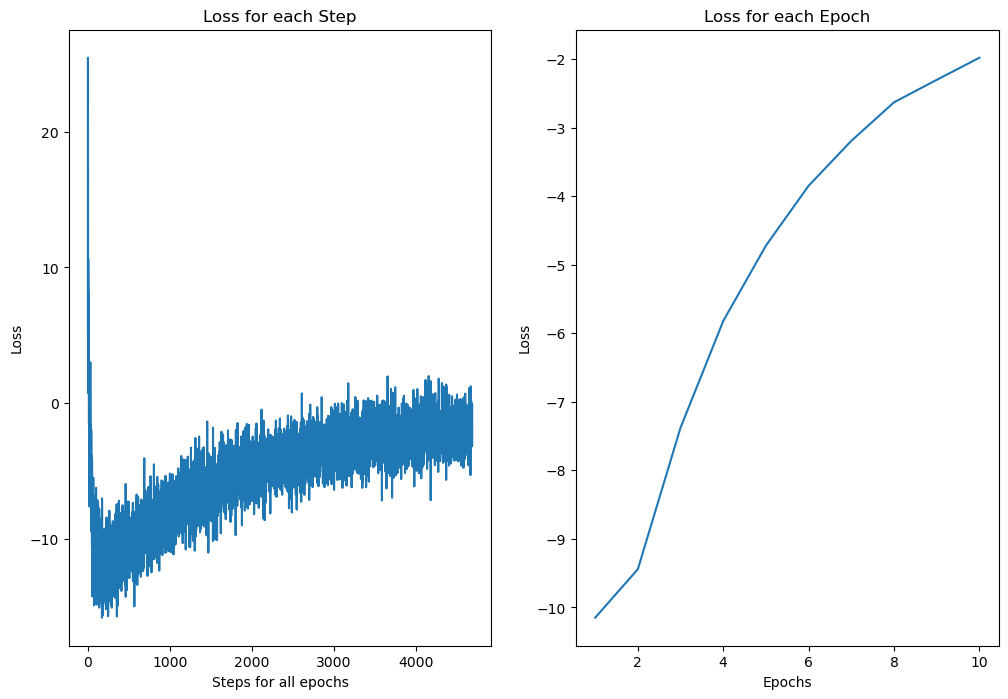

In [3]:
# --- Save RBM
save_model(rbm, "rbm.pth")
# --- Plot loss function
plot_loss(epochs, loss_, loss_epochs)

The loss function used for training RBMs is the Negative Log-Likelihood function. That function is defined as the negative log of the observed data probability under the model. Yet, the probability distribution can't be easily computed. 

So we estimate the gradient of the log-likelihood function by a Monte Carlo method, in which a Markov Chain Monte Carlo procedure is used to generate "fantasy samples" from the model's distribution, starting from an observed or "real" data point. These "fantasy samples" are then used to update the model parameters via gradient descent, in order to minimize the difference between the model's distribution and the observed data distribution.

Now let's visualize the **weight matrix** and also some generated images :

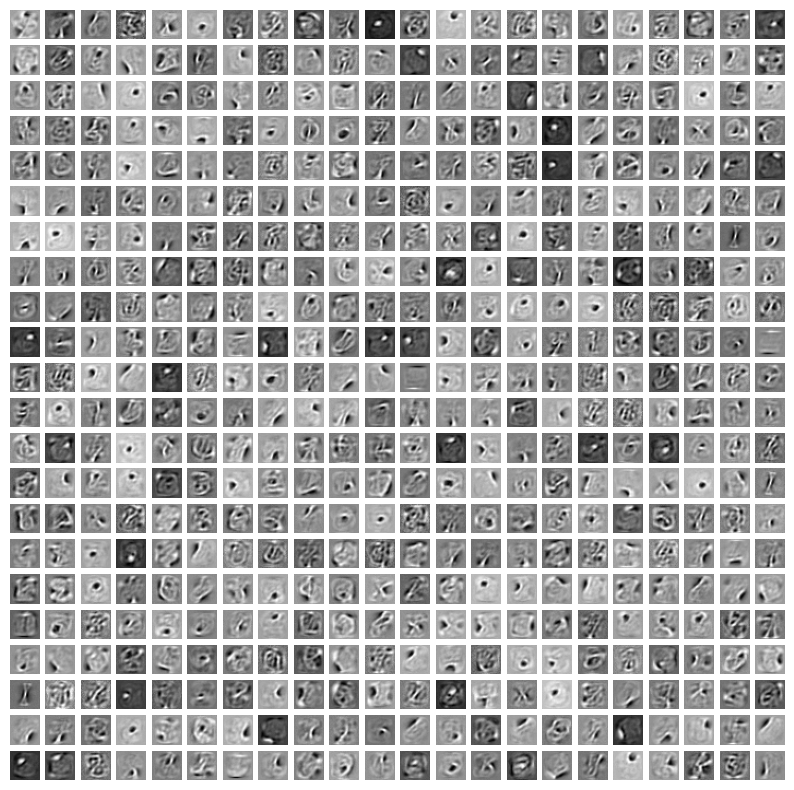

In [4]:
# --- Extract the weights from the RBM
weights = rbm.W.detach().numpy()

# --- Display the weights
plot_weights(weights)

The weight matrix contains the learned representations from the training dataset. In other words, it can reveal the types of visual patterns learned from the MNIST dataset. In our case, we can see that the RBM has learned to represent digit shapes in a very abstract way.

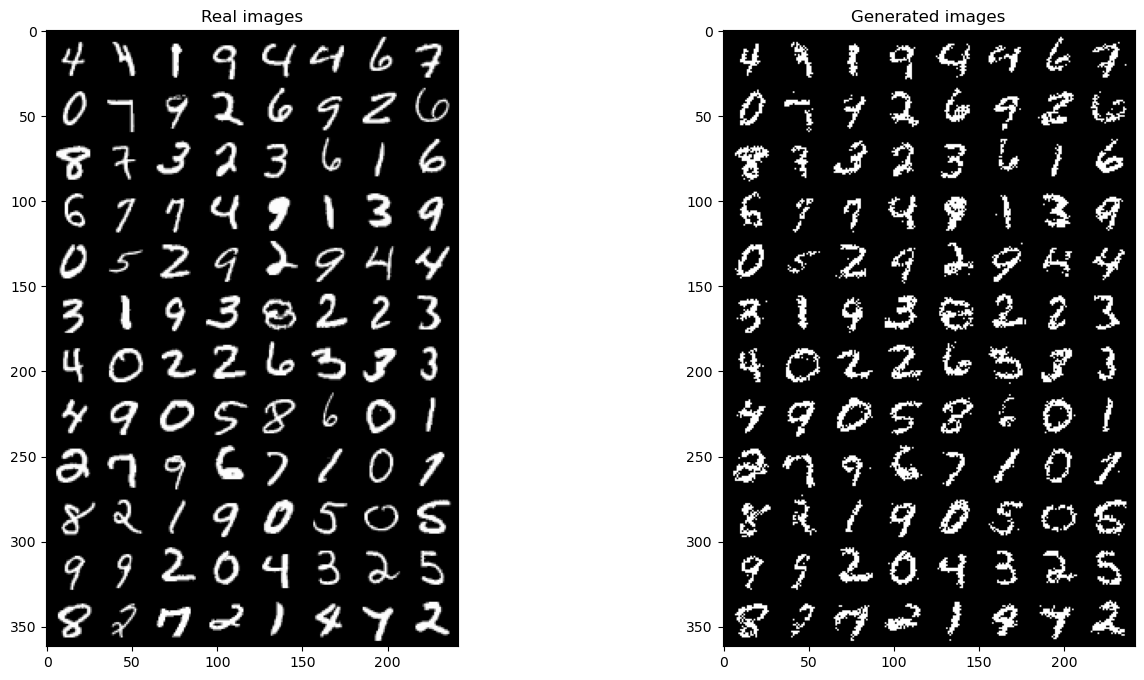

In [5]:
# --- Real images vs generated images
plot_save_image("example_12", make_grid(v.view(96, 1, 28, 28).data), make_grid(v1.view(96, 1, 28, 28).data))

We notice that generated images look almost similar to the real images. As a consequence, it suggests that the RBM has learned well the probability distribution over the input data (and capture the important feature of the data).

# Classification on MNIST dataset with RBM

---
---

Now that we have trained our RBM, we can use the created features to classify the MNIST dataset thanks to ML algorithms :

In [5]:
# --- Import packages
from utils import plot_tsne, evaluate_model

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import warnings

# --- Learn RBM features
train = train_dataset.data.numpy().reshape(-1, 784)
test = test_dataset.data.numpy().reshape(-1, 784)
train_label = train_dataset.targets.numpy()
test_label = test_dataset.targets.numpy()

train_reduced, _ = rbm.v_to_h(torch.Tensor(train))
test_reduced, _ = rbm.v_to_h(torch.Tensor(test))
train_reduced = train_reduced.detach().numpy()
test_reduced = test_reduced.detach().numpy()

We could look at the potential of RBM features to well separate digits before any classification :

t-SNE on train dataset


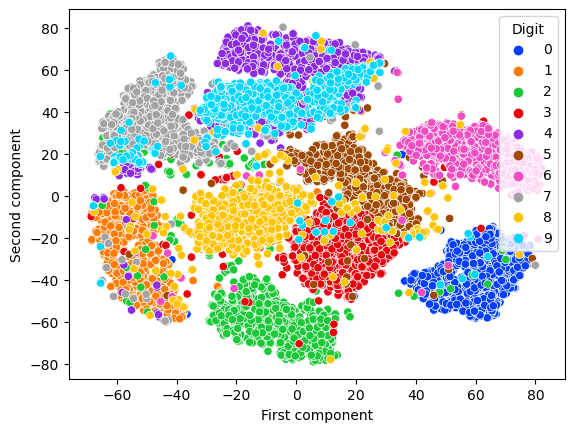

t-SNE on train dataset with RBM features


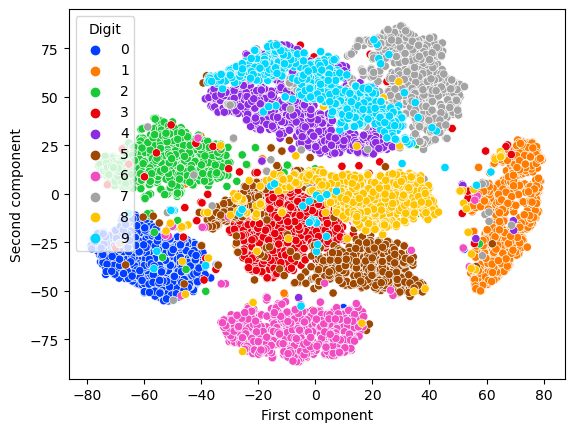

t-SNE on test dataset


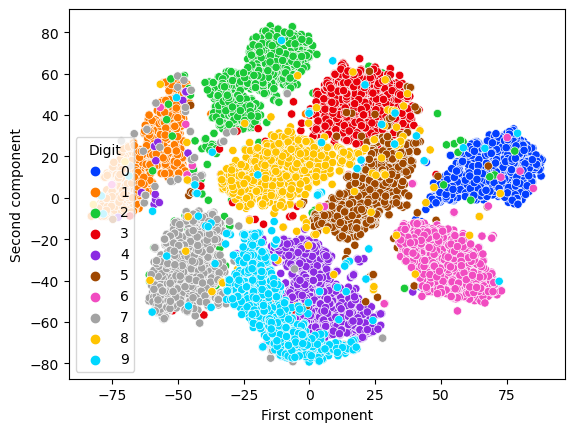

t-SNE on test dataset with RBM features


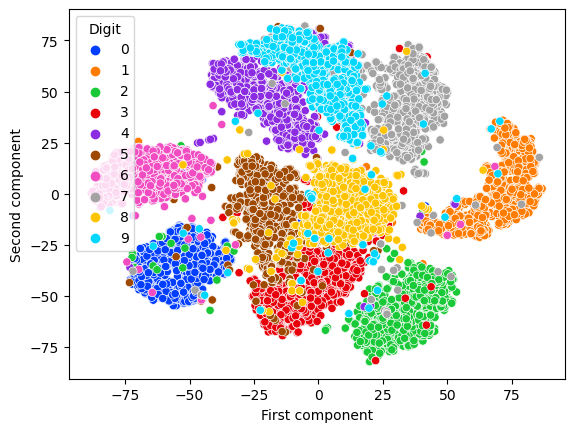

In [6]:
rand_idx = np.random.choice(train.shape[0], 10000, replace=False)

print("t-SNE on train dataset")
plot_tsne(train[rand_idx], train_label[rand_idx])
print("t-SNE on train dataset with RBM features")
plot_tsne(train_reduced[rand_idx], train_label[rand_idx])

print("t-SNE on test dataset")
plot_tsne(test, test_label)
print("t-SNE on test dataset with RBM features")
plot_tsne(test_reduced, test_label)

Here, we will classify on RBM features but also on the original dataset to compare their results :

=======Logistic Regression=======
Logistic Regression Accuracy: 0.95


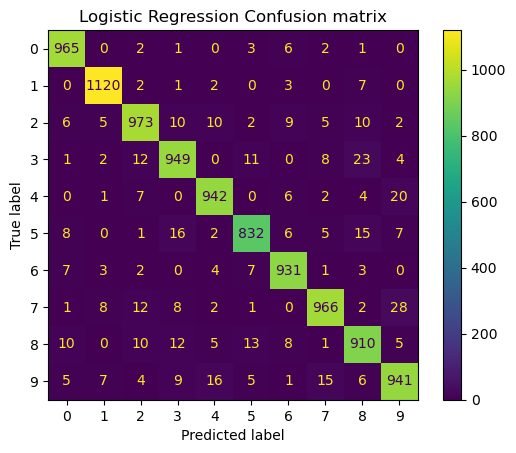

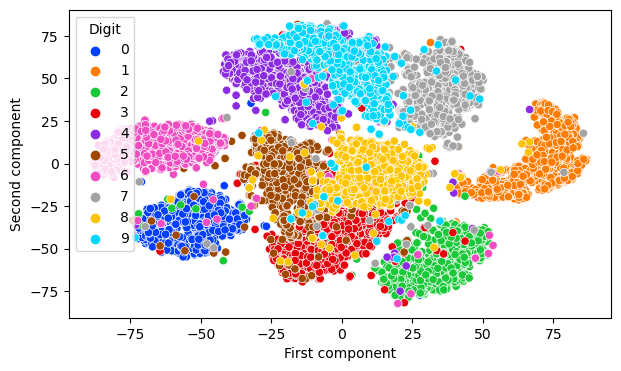

=======LDA=======
LDA Accuracy: 0.93


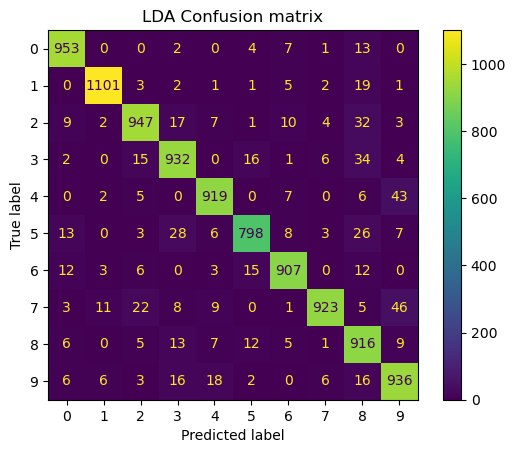

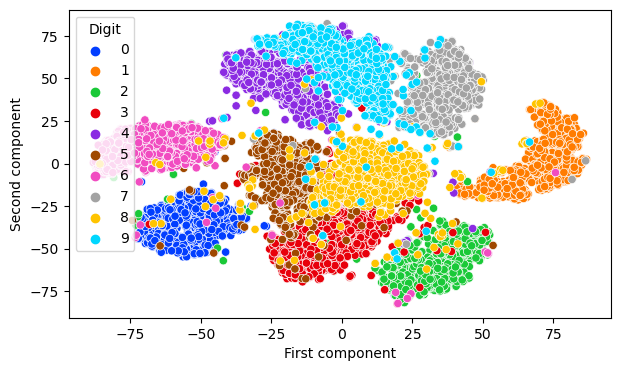

=======Linear SVM=======
Linear SVM Accuracy: 0.95


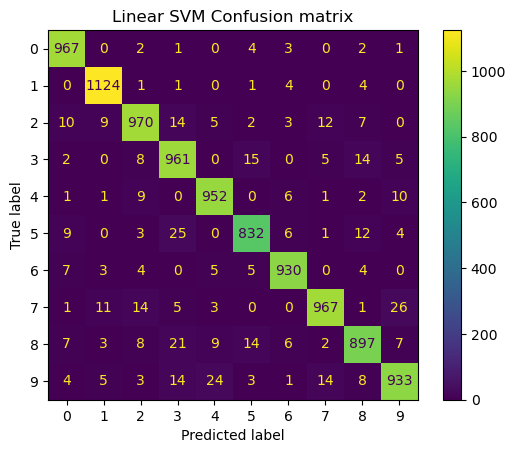

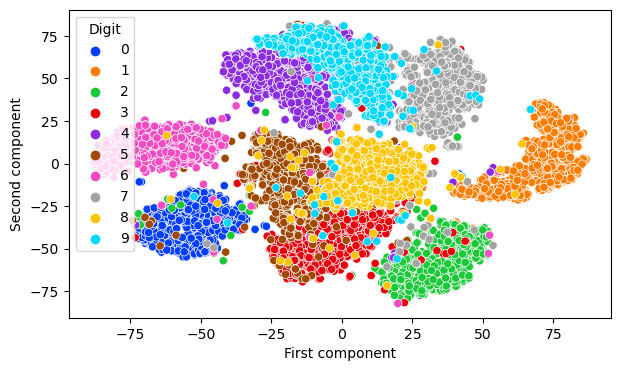

=======Gaussian SVM=======
Gaussian SVM Accuracy: 0.98


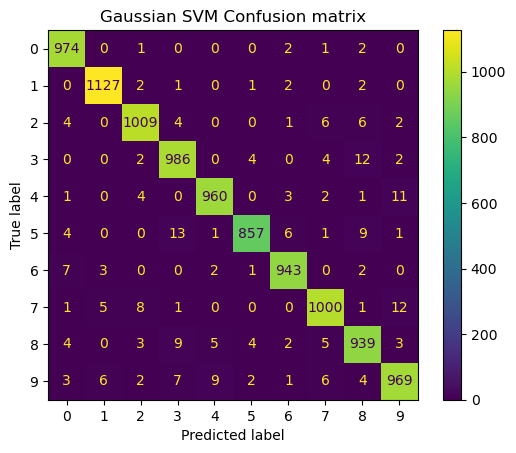

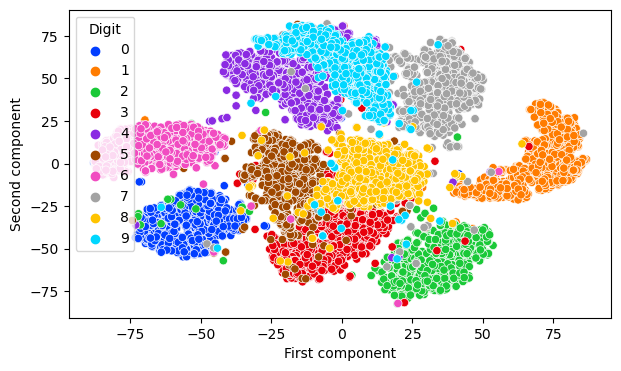

=======KNN=======
KNN Accuracy: 0.96


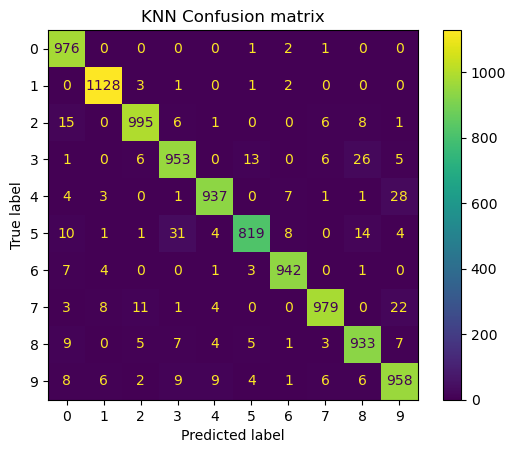

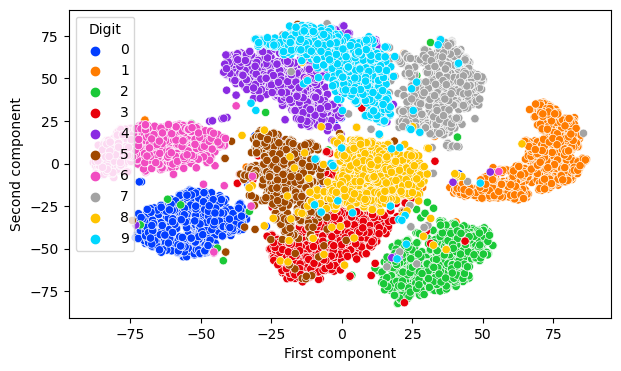

=======Random Forest=======
Random Forest Accuracy: 0.97


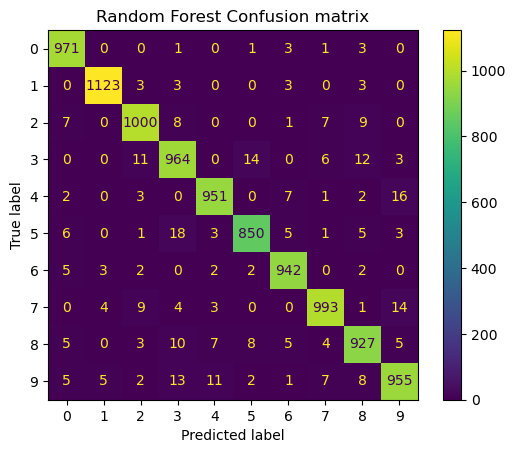

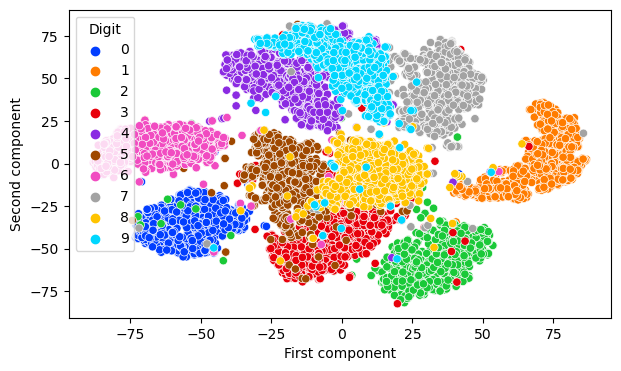

=======Gradient Boosting=======
Gradient Boosting Accuracy: 0.95


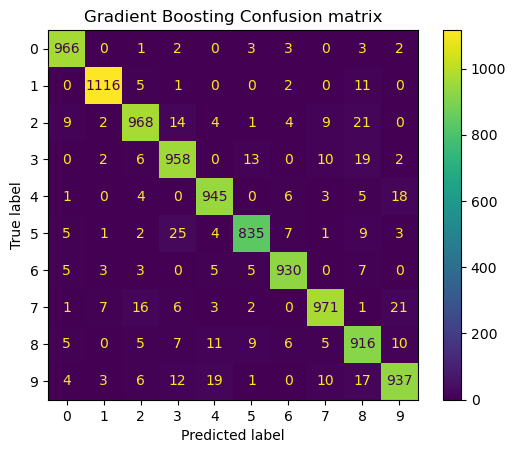

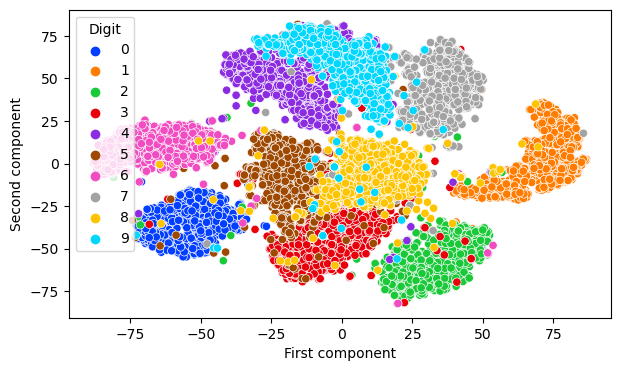

=======MLP=======
MLP Accuracy: 0.98


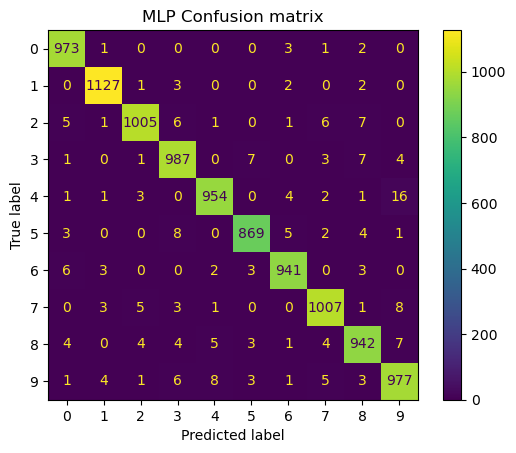

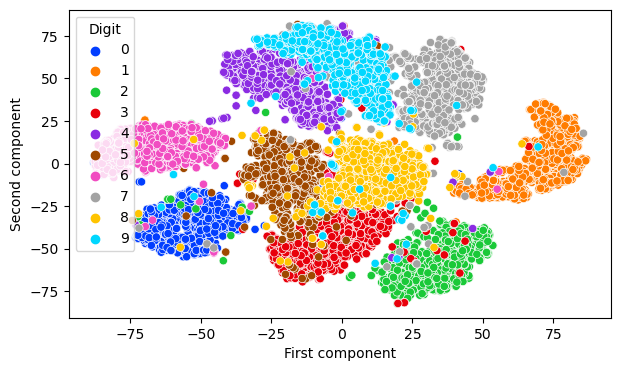

CPU times: total: 54min 3s
Wall time: 32min 14s


In [7]:
%%time

# --- Train classifiers on RBM features
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "LDA": LinearDiscriminantAnalysis(),
    "Linear SVM": SVC(kernel="linear"),
    "Gaussian SVM": SVC(kernel="rbf"),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1),
    "MLP": MLPClassifier(hidden_layer_sizes=(500, 500)),
}

for name, model in models.items():
    print(f"======={name}=======")
    evaluate_model(train_reduced, test_reduced, train_label, test_label, model, name)

In [ ]:
"""
# /!\ takes a lot of time to run
%%time

# --- Train classifiers on the original dataset
models = {
    "naive Logistic Regression": LogisticRegression(max_iter=2000),
    "naive LDA": LinearDiscriminantAnalysis(),
    "naive Linear SVM": SVC(kernel="linear"),
    "naive Gaussian SVM": SVC(kernel="rbf"),
    "naive KNN": KNeighborsClassifier(n_neighbors=3),
    "naive Random Forest": RandomForestClassifier(),
    "naive Gradient Boosting": GradientBoostingClassifier(learning_rate=1),
    "naive MLP": MLPClassifier(hidden_layer_sizes=(500, 500)),
}

for name, model in models.items():
    print(f"======={name}=======")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        evaluate_model(train, test, train_label, test_label, model, name)
"""

We are surprised to see that the ML algorithms, such as logistic regression, are able to well separate the digits thanks to RBM features without hyperparametrization. In fact, if we use such models without any preprocessing on MNIST dataset, the accuracy will be relatively low. This is because the MNIST images (after vectorization) correspond to a 784-dimensional vector which is hard to use :

* The number of features is high and it must be difficult to work with. This can lead to the **curse of dimensionality**, where the model has difficulty generalizing to new data beacause of the large number of dimensions.
* The pixels in each image are **highly correlated spatially**. This can make it difficult for ML classifiers to separate out the different classes of digits.
* Models take larger time to train on such high dimensional data.

To conclude, we can conclude that the RBM learned well relevant and informative features from the MNIST dataset. And these features can be used to train ML classifiers on the MNIST dataset. 